<div>
<h1>Run the cell below to generate the road map (do not modify it)</h1></div>

In [1]:
%%javascript
var kernel = IPython.notebook.kernel;
var thename = window.document.getElementById("notebook_name").innerHTML;
var command = "THE_NOTEBOOK = " + "'"+thename+"'";
kernel.execute(command);command="os.environ['THE_NOTEBOOK'] = THE_NOTEBOOK";
kernel.execute(command);var cell = IPython.notebook.get_cell(2);cell.execute();
IPython.notebook.get_cell(3).focus_cell();
var x = $('.code_cell');$(x[1]).children('.input').hide();

<IPython.core.display.Javascript object>

In [2]:
outputdir = "/tmp/tools/"
!mkdir -p $outputdir
!wget "https://www.dropbox.com/s/4g0pigmro4vo1b4/menutemplate?dl=0" -O /tmp/tools/menutemplate >> /tmp/toollog 2>&1 
!wget "https://www.dropbox.com/s/3flttpzhsja8td7/construct_menu.py?dl=0" -O /tmp/tools/construct_menu.py >> /tmp/toollog 2>&1 
!python /tmp/tools/construct_menu.py "{THE_NOTEBOOK}.ipynb" {outputdir}
from IPython.core.display import HTML
output_file_name = outputdir + THE_NOTEBOOK.replace(" ", "").replace("[", "").replace("]", "") + ".ipynb.html"
with open(output_file_name) as fp:
    html = fp.read()
HTML(html)

In this notebook, we will learn how to solve the regression problem of predicting flight delays, using decision trees and random forests.

# Goals
The main goals of this project are as follows:
1. Revisit the concepts behind Decision Trees and Random Forests
2. Build a simple methodology to address Data Science projects
3. Use the existing implementation of Random Forests in MLLib in a specific use case, that is to predict the delay of flights

# Steps

- First, in section 1, we will go through a short introduction about the fudamentals of Decision Trees and Random Forsests, such as feature definition, the form of a decision tree, how does it work and the idea of a forest of decision trees. If the student is familiar with these topics, skip to section 2.
- In section 2, we delve into the details of the use case of this notebook including: providing the context, introducing the data and the basic methodology to address the project in this notebook
- In section 3, we perform data exploration
- In section 4, we build the statistical model and validate it

# 1. Decision trees and Random Forests: Simple but Powerful Algorithms
> Prediction is very difficult, especially if it’s about the future. (Niels Bohr)

Decision trees are a very popular approach to prediction problems. Decision trees can be trained from both categorical and numerical features, to perform classification and regression. Classification and regression are the oldest and most well-studied types of predictive analytics. In many analytics packages and libraries, most algorithms are devoted either to address classification or regression problems, and they include for example support vector machines (SVM), neural networks, naïve Bayes, logistic regression, and deep learning...

In general, classification refers to the problem of predicting a label, or category, like *spam/not spam*, *rainy/sunny/mild*, for some given data. Regression refers to predicting a numeric quantity like salary, temperature, delay time, product's price. Both classification and regression involve predicting one (or more) values given one (or more) other input values. They require labelled data to perform a training phase, which builds the statistical model: they belong to *supervised learning* techniques.

## 1.1 Feature definition
To understand how regression and classification operate, it is necessary to briefly define the terms that describe their input and output. 

Assume that we want to predict the temperature of tomorrow given today's weather information.
The weather information is a loose concept. For example, we can use many variables to express today's weather such as:
* the average humidity today
* today’s high temperature
* today’s low temperature 
* wind speed
* outlook: e.g. cloudy, rainy, or clear
* ....

These variables are called *features* or *demensions*. 

Each variable can be quantified. For example, high and low temperatures are measured in degrees Celsius, humidity can be measured as a fraction between 0 and 1, and weather type can be labeled `cloudy`, `rainy` or `clear`...
So, the weather today can be expressed by a list of values: `11.4, 18.0, 0.64, 20, cloudy`
Each feature is also called a `predictor`. Together, they constitute a `feature vector`.

A feature whose domain is a set of categories is called **categorical feature**. In our example, `outlook` is a  categorical feature. A feature whose values are numerical is called **numerical feature**. In our example, `temperature` is a numerical feature.

Finally, tomorrow's temperature, that is what we want to predict, is called *target feature*.

## 1.2 Decision Trees & Random Forests
The first question that you might ask is: "Why Decision trees and not another approach?"

Well, the literature shows that the family of algorithms known as decision trees can naturally handle both categorical and numeric features. The training process is easy to understand. The model is easy to interpret. They are robust to outliers in the data, meaning that a few extreme and possibly erroneous data points should not affect the tree at all. The model can be trained in parallel easily. The accuracy is comparable to other methods... In short, there are lots of advantages when using decision trees with respect to other methods! 

The way we use a tree model is very simple to understand. We can say that this process "mimics" the way humans take decisions. For example, to decide whether to play football or not, a natural questions would be "does it rain now ?". If yes, the decision is `no`. If it's sunny, the condition is favorable to play football. A second natural question could be: "is it windy?". If no, then you may want to stay at home because otherwise it is going to be too hot. Otherwise, a third plausible question could be: "do we have enough people?". If no, then there's no point playing. Otherwise, time to play!

Using a decision tree allows to follow a similar process to that described above (see the image below). Given a new input, the algorithm traverses the tree in a such a way that the input satisfies the condition of each node until reaching a leaf one. The value of the leaf node is the decision.

![A decision tree](https://farm2.staticflickr.com/1690/24308350756_8533286fb5_z.jpg)

The tree model in the figure is built from historical information concerning many past days. The `feature predictor` contains three features: Rain, Is_Windy, Enough_People.
An example of the training data is as follows:

Rain | Is_Windy | Enough_People | Play
-----|----------|---------------|------
Yes | Yes | No | No
No  | No | No | No
No | Yes | Yes | Yes
No | No | Yes | No

As you can see, in the training data, we know the values of predictors and we also know the corresponding answer: we have the ground truth.

One limitation of decision trees is that it's easy to incur in overfitting problems. In other words, the model is too fit to the training data, it is too precise and not general enough. So, when testing the quality of predictions with different testing sets, accuracy could fluctuate. To overcome this limitation, the tree can be pruned after it is built, or even be pruned during the training process. Another approach is building a `Random Decision Forest`.

A `Random Decision Forest`, as its name implies, is a forest of random Decision trees. Each tree element is built randomly from the training data. Randomization generally applies to:
* Building new training data: Random selectiion of samples from the training data (with replacement) from the original training data
* When building a node: Random selection of a subset of features

To take a decision, the forest "asks" all trees about their prediction, and then chooses the outcome which is the most voted.

# 2. Usecase : Flights delay prediction
## 2.1 Context
Every day, in US, there are thousands of flights departures and arrivals: unfortunately, as you may have noticed yourself, flight delays are not a rare event!! Now, given historical data about flights in the country, including the delay information that was computed *a-posteriori* (so the ground truth is available), we want to build a model that can be used to predict how many minutes of delay a flight might experience in the future. This model should provide useful information for the airport to manage better its resources, to minimize the delays and their impact on the jurney of its passengers. Alternatively, astute passengers could even use the model to choose the best time for flying, such as to avoid delays.

## 2.2 Data
The data we will use in this notebook has been collected by the RITA (Research and Inovative Technology Administration), and it contains details facets about each air flight that happened in the US between 1987 and 2008. It includes 29 variables such as the origin airport, the destination airport, the scheduled departured time, day, month, the arrival delay... For more information, please visit the following [link](http://stat-computing.org/dataexpo/2009/the-data.html), that provides a lot of detail on the data. Our goal is to build a model to predict `the arrival delay`.

## 2.3 Methodology
For our project, we can follow a simple methodology:

- Understand clearly the context, the data and the goal of the project
- Pre-process the data (data cleaning): the data can contain invalid values or missing values. We have to process our data to deal with them
- Retrieve descriptive information about data: the idea is to discover if whether the data has patterns, whether features have patterns, the skew of values...
- Select appropriate features: Only work with significant features will save us memory, communication cost, and ultimately, training time. Feature selection is also important as it can reduce the impact of noise that characterize the unimportant features.
- Divide the data into training and testing set
- Build a model from the feature in the training set
- Test the model

# 3. Let's play: Data Exploration
Now it's time to apply the simple methodology outlined in section 2.3 on the usecase of this notebook.

**Note:** The source code in this lecture should be executed sequentially in the order.

## 3.1 Understanding the data schema

The data has 29 features, that can be either categorical or numerical. For example, the `src_airport` (source airport) is categorical: there exist no comparision operator between airport names. We can not say "SGN is bigger than NCE". The departure is numerical, for which a comparison operator exists. For instance, "flight departing before 6PM" can be express by "departure_time < 1800".

In this usecase, most features are numerical, except `carier`, `flight_number`, `cancelled`, `cancelation_code` and `diverted`. 

The data contains a header, that is useless in building the statistical model. In addition, we already know the data schema, so we can safely neglect it. Note that there are some features with missing values in some lines of the dataset. The missing values are marked by "NA". These values can cause problems when processing and can lead to unexpected results. Therefore, we need to remove the header and replace all "NA" values by empty values, such as they can be interpreted as null values.

As we have seen already, there are multiple ways to manipulate data:

- Using the RDD abstraction
- Using the DataFrame abstraction. DataFrames can be thought of as distributed tables: each item is a list of values  (the columns). Also, the value in each row of each column can be accesed by the column's name.

Next, we will focus on using DataFrames. However, to use DataFrames, the data must be clean (no invalid values). That means we can not create DataFrame directly from the "RAW" data. Instead, we will first create an RDD from RAW data, produce a new, clean RDD, then transform it to a DataFrame and work on it. The RDD `cleaned_data` is an RDD[String]. We need to transform it to RDD[(TypeOfColumn1, TypeOfColumn2,.., TypeOfColumn29)] then call a function to create a DataFrame from the new RDD.


## 3.2 Data cleaning
Let's prepare for the cleaning step: Loading the data into an RDD.

First, we need to import some useful python modules for this notebook.

In [3]:
import os
import sys
import re
from pyspark import SparkContext
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql import Row
from pyspark.sql.functions import *
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pyspark.sql.functions as func
import matplotlib.patches as mpatches

# to start testing, we can focus on a single year
input_path = "/datasets/airline/1994.csv"
raw_data = sc.textFile(input_path)

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

<div class='anchor' ></div>
### Question 1 
Remove the header and replace the invalid values in our input dataset.

#### Question 1.1
How many records (rows) in the RAW data ?

In [4]:
print("number of rows before cleaning:", raw_data.count())

number of rows before cleaning: 5180049


<div class='anchor' ></div>
#### Question 1.2
Except for the first column, the others might contain missing values, which are denoted by `NA`. Remove the header and replace NA by an empty character. How many records are left after cleaning the RAW dataset?

NOTE: be careful with the valid values that can contain string `NA` inside.



In [4]:
# extract the header
header = raw_data.first()

# replace invalid data with NULL and remove header
cleaned_data = (raw_data\
        # filter out the header
        .filter(lambda l: l != header)
        # replace the missing values with empty characters
        .map(lambda l: l.replace('NA', ''))
        )
        
print("number of rows after cleaning:", cleaned_data.count())

number of rows after cleaning: 5180048


## 3.3 Transforming our data to a DataFrame

Now the data is clean, valid and can be used to create DataFrame. First, we will declare the data schema for the DataFrame. By doing that, we can specify the name and data type of each column.

In [5]:
sqlContext = SQLContext(sc)


# Declare the data schema
# see http://stat-computing.org/dataexpo/2009/the-data.html
# for more information
airline_data_schema = StructType([ \
    #StructField( name, dataType, nullable)
    StructField("year",                     IntegerType(), True), \
    StructField("month",                    IntegerType(), True), \
    StructField("day_of_month",             IntegerType(), True), \
    StructField("day_of_week",              IntegerType(), True), \
    StructField("departure_time",           IntegerType(), True), \
    StructField("scheduled_departure_time", IntegerType(), True), \
    StructField("arrival_time",             IntegerType(), True), \
    StructField("scheduled_arrival_time",   IntegerType(), True), \
    StructField("carrier",                  StringType(),  True), \
    StructField("flight_number",            StringType(),  True), \
    StructField("tail_number",              StringType(), True), \
    StructField("actual_elapsed_time",      IntegerType(), True), \
    StructField("scheduled_elapsed_time",   IntegerType(), True), \
    StructField("air_time",                 IntegerType(), True), \
    StructField("arrival_delay",            IntegerType(), True), \
    StructField("departure_delay",          IntegerType(), True), \
    StructField("src_airport",              StringType(),  True), \
    StructField("dest_airport",             StringType(),  True), \
    StructField("distance",                 IntegerType(), True), \
    StructField("taxi_in_time",             IntegerType(), True), \
    StructField("taxi_out_time",            IntegerType(), True), \
    StructField("cancelled",                StringType(),  True), \
    StructField("cancellation_code",        StringType(),  True), \
    StructField("diverted",                 StringType(),  True), \
    StructField("carrier_delay",            IntegerType(), True), \
    StructField("weather_delay",            IntegerType(), True), \
    StructField("nas_delay",                IntegerType(), True), \
    StructField("security_delay",           IntegerType(), True), \
    StructField("late_aircraft_delay",      IntegerType(), True)\
])

To "convert" an RDD to DataFrame, each element in the RDD must be a list of column values that match the data schema.

In [6]:
# convert each line into a tuple of features (columns)
cleaned_data_to_columns = cleaned_data.map(lambda l: l.split(","))\
    .map(lambda cols: 
         (
            int(cols[0])  if cols[0] else None,
            int(cols[1])  if cols[1] else None,
            int(cols[2])  if cols[2] else None,
            int(cols[3])  if cols[3] else None,
            int(cols[4])  if cols[4] else None,
            int(cols[5])  if cols[5] else None,
            int(cols[6])  if cols[6] else None,
            int(cols[7])  if cols[7] else None,
            cols[8]       if cols[8] else None,
            cols[9]       if cols[9] else None,
            cols[10]      if cols[10] else None,
            int(cols[11]) if cols[11] else None,
            int(cols[12]) if cols[12] else None,
            int(cols[13]) if cols[13] else None,
            int(cols[14]) if cols[14] else None,
            int(cols[15]) if cols[15] else None,
            cols[16]      if cols[16] else None,
            cols[17]      if cols[17] else None,
            int(cols[18]) if cols[18] else None,
            int(cols[19]) if cols[19] else None,
            int(cols[20]) if cols[20] else None,
            cols[21]      if cols[21] else None,
            cols[22]      if cols[22] else None,
            cols[23]      if cols[23] else None,
            int(cols[24]) if cols[24] else None,
            int(cols[25]) if cols[25] else None,
            int(cols[26]) if cols[26] else None,
            int(cols[27]) if cols[27] else None,
            int(cols[28]) if cols[28] else None
         ))

To train our model, we use the following features: `year`, `month`, `day_of_month`, `day_of_week`, `scheduled_departure_time`, `scheduled_arrival_time`, `arrival_delay`, `distance`, `src_airport`, `dest_airport`.

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

<div class='anchor' ></div>
### Question 2

From RDD `cleaned_data_to_columns` and the schema `airline_data_schema` which are declared before, create a new DataFrame **`df`**.

Note that, we should only select the necessary features defined above: [ year, month, day_of_month, day_of_week, scheduled_departure_time, scheduled_arrival_time, arrival_delay, distance, src_airport, dest_airport]. 

Finally, the data should be cached.

In [7]:
# create dataframe df
df = (sqlContext.createDataFrame(cleaned_data_to_columns, airline_data_schema)\
    .select(['year', 'month', 'day_of_month', 'day_of_week',
            'scheduled_departure_time','scheduled_arrival_time',
            'arrival_delay', 'distance', 
            'src_airport', 'dest_airport', 'carrier'])\
    .cache())

## 3.4 Descriptive statistics
Next, we will go over a series of simple queries on our data, to explore it and compute statistics. These queries directly map to the questions you need to answer. 

**NOTE:** finding the right question to ask is difficult! Don't be afraid to complement the questions below, with your own questions that, in your opinion, are valuable ways to inspect data. This can give you extra points!

- Basic queries:
  - How many unique origin airports ?
  - How many unique destination airports ?
  - How many carriers ?
  - How many flights that have a scheduled departure time later than 18h00 ?
  
- Statistic on flight volume: this kind of statistics are helpful to reason about delays. Indeed, it is plausible to assume that "*the more flights in an airport, the higher the probability of delay*".
  - How many flights in each month of the year ?
  - Is there any relationship between the number of flights and the days of week?
  - How many flights in different days of months and in different hours of days ?
  - Which are the top 20 busiest airports (this depends on inbound and outbound traffic) ?
  - Which are the top 20 busiest carriers ?
  
- Statistic on the fraction of delayed flights
  - What is the percentage of delayed flights (over total flights) for different hours of the day ?
  - Which hours of the day are characterized by the longest flight delay ?
  - What are the fluctuation of the percentage of delayed flights over different time granularities ?
  - What is the percentage of delayed flights which depart from one of the top 20 busiest airports ?
  - What is the percentage of delayed flights which belong to one of the top 20 busiest carriers ?

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

<div class='anchor' ></div>
### Question 3: Basic queries

#### Question 3.1 
How many origin airports ? How many destination airports ?

In [9]:
num_src_airport = df.select('src_airport').distinct().count()
num_dest_airport = df.select('dest_airport').distinct().count()
print("number of origin airports ", num_src_airport)
print("number of destination airports ", num_dest_airport)

number of origin airports  224
number of destination airports  225


<div class='anchor' ></div>
#### Question 3.2
How many carriers ?

In [9]:
num_carrier = df.select('carrier').distinct().count()
print("the number distinct carriers:", num_carrier)

the number distinct carriers: 10


<div class='anchor' ></div>
#### Question 3.3
How many night flights (that is, flights departing later than 6pm) ?

In [11]:
print("the number of night flights:", df[df.scheduled_departure_time > 1800].count())

the number of night flights: 1078203


![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

<div class='anchor' ></div>
### Question 4: Flight volume statistics

#### Question 4.1: 
How many flights in each month of the year? Plot the changes over months by a line chart and comment the figure.
From the result, we can learn the dynamics of flight volume over months. For example, if we only consider flights in 1994 (to start, it's always better to focus on smaller amount of data), we can discuss about which months are most likely to have flights experiencing delays.

+-----+------+
|month| count|
+-----+------+
|    1|423861|
|    2|386954|
|    3|435516|
|    4|420995|
|    5|436432|
|    6|426490|
|    7|443736|
|    8|451086|
|    9|430861|
|   10|449369|
|   11|428227|
|   12|446521|
+-----+------+



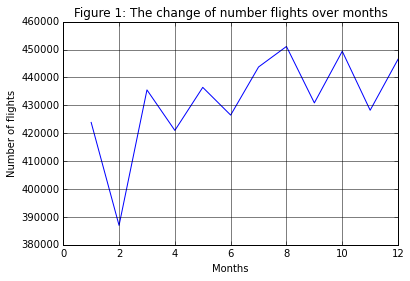

In [12]:
statistic_month = df.groupBy(df.month).count()
statistic_month.show()
pdf = pd.DataFrame(data=statistic_month.take(12))
plt.xlabel("Months")
plt.ylabel("Number of flights")
plt.title('Figure 1: The change of number flights over months')
plt.grid(True,which="both",ls="-")
plt.plot(range(1,13), pdf[1])
plt.show()

<div class="comment">
There's more traffic in July, August (Summer hollidays), October and December (chrismas and New Year), so there might be more delays during those periods (higher utilization of the system).

On the contrary, experiencing delays in february is less likely : indeed, we can see an important drop of the traffic at this period of the year.
</div>

<div class='anchor' ></div>
#### Question 4.2: 
Is there any relationship between the number of flights and the days of the week? Plot a bar chart and interpret the figure.
By answering this question we could learn about the importance of the weekend/weekday feature for our predictive task.

+-----------+------+
|day_of_week| count|
+-----------+------+
|          1|754636|
|          2|756532|
|          3|756864|
|          4|751537|
|          5|751531|
|          6|695245|
|          7|713703|
+-----------+------+



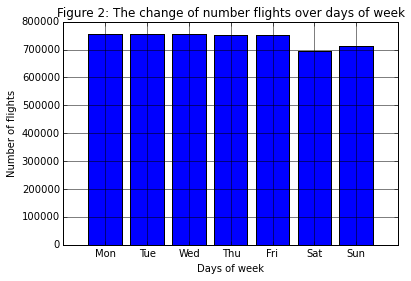

In [13]:
statistic_day_of_week = df.groupBy(df.day_of_week).count()
statistic_day_of_week.show()
pdf = pd.DataFrame(statistic_day_of_week.take(7))
plt.xlabel("Days of week")
plt.ylabel("Number of flights")
plt.title('Figure 2: The change of number flights over days of week')
plt.grid(True,which="both",ls="-")
map_int_into_day = { 1:"Mon", 2:"Tue", 3:"Wed", 4:"Thu", 5:"Fri", 6:"Sat", 7:"Sun" }
day_of_week_label = pdf[0].map(lambda i: map_int_into_day[i])

# plot bar chart
plt.bar( range(1,8), pdf[1], align='center')

plt.xticks(pdf[0], day_of_week_label)
plt.show()

<div class="comment">
The traffic is pretty much the same every day of the week. However there is a slight drop in the traffic on weekends : we expect less delay those days.
</div>

<div class='anchor' ></div>
#### Question 4.3
How many flights in different days of months and in different hours of days ? Plot  bar charts, and interpret your figures.

+------------+------+
|day_of_month| count|
+------------+------+
|           1|169674|
|           2|169829|
|           3|168678|
|           4|169399|
|           5|168423|
|           6|170650|
|           7|172210|
|           8|170674|
|           9|170077|
|          10|170252|
|          11|172362|
|          12|169542|
|          13|171230|
|          14|172081|
|          15|170737|
|          16|169985|
|          17|170132|
|          18|171868|
|          19|169483|
|          20|171142|
+------------+------+
only showing top 20 rows



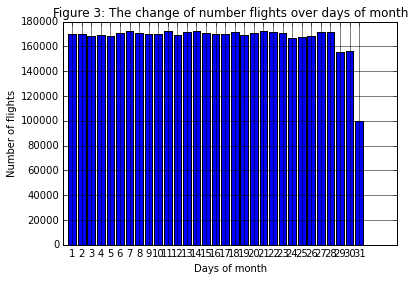

In [14]:
statistic_day_of_month = df.groupBy(df.day_of_month).count().orderBy('day_of_month',ascending=1)
statistic_day_of_month.show()
pdf = pd.DataFrame(statistic_day_of_month.take(31))
plt.xlabel("Days of month")
plt.ylabel("Number of flights")
plt.title('Figure 3: The change of number flights over days of month')
plt.grid(True,which="both",ls="-")

# plot bar chart
plt.bar( pdf[0], pdf[1], align='center')

plt.xticks(pdf[0])
plt.show()

<div class="comment">
The drop of traffic on the 31st isn't relevant, because there are less 31st in the year than other days. The same logic applies to the 29th and the 30th.
There is no interesting pattern in this chart.
</div>

[13641, 12825, 2842, 564, 486, 13357, 257486, 398796, 397060, 341597, 300375, 313577, 356830, 360762, 294214, 313131, 317809, 368695, 338147, 287033, 232898, 168138, 52395, 37389]


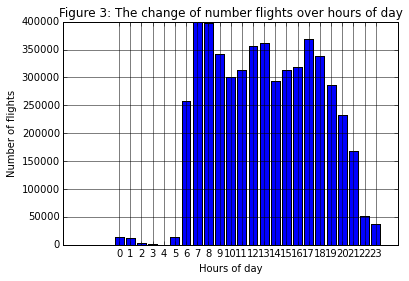

In [15]:
#statistic_hour_of_day = df.groupBy(df.scheduled_departure_time).count().orderBy('scheduled_departure_time',ascending=1)
#statistic_hour_of_day.show()

#pdf = pd.DataFrame(statistic_hour_of_day.take(760))

L = list()
for h in range(0,24):
    L.append(df[(df.scheduled_departure_time < 100*h+60) & (df.scheduled_departure_time >= 100*h)].count())
print(L)    
plt.xlabel("Hours of day")
plt.ylabel("Number of flights")
plt.title('Figure 3: The change of number flights over hours of day')
plt.grid(True,which="both",ls="-")
# plot bar chart
plt.bar( range(0,len(L)), L, align='center')
plt.xticks(range(0,len(L)))
plt.show()

<div class="comment">
The very big part of the traffic happens during the day (6AM to 9PM). We have a peak in the morning around 7AM (the working travellers ?). we can also notice that the number of flight decrease the evening, from 6PM to 4AM the day after.
</div>

<div class='anchor' ></div>
#### Question 4.4
Which are the top 20 busiest airports: compute this in terms of aggregate inbound and outbound number of flights ?

In [16]:
# consider outbound flights
stat_src = (df
            .groupBy(df.src_airport)
            .agg(func.count('*').alias('count1'))
            )
    
# consider inbound flights
stat_dest = (df
            .groupBy(df.dest_airport)
            .agg(func.count('*').alias('count2'))
            )


# full join the statistic of inbound flights and outbound flights
stat_airports = stat_src.join(stat_dest, stat_src.src_airport == stat_dest.dest_airport, how = 'outer')
stat_airports.show()

# TOP 20 BUSIEST AIRPORTS
stat_airport_traffic = (stat_airports
                            # define the new column `total` 
                            # which has values are equal to the sum of `count1` and `count2`
                            .withColumn('total', stat_airports['count1'] + stat_airports['count2'])
                            # select top airpoint in termns of number of flights
                            .select(['src_airport','total']).orderBy(desc('total'))
                        )
stat_airport_traffic.show(20)

+-----------+------+------------+------+
|src_airport|count1|dest_airport|count2|
+-----------+------+------------+------+
|        IAH|104182|         IAH|104409|
|        GEG|  8392|         GEG|  8275|
|        TUS| 15909|         TUS| 15631|
|        STL|151609|         STL|152800|
|        CMH| 40952|         CMH| 40599|
|        BRO|  1105|         BRO|  1081|
|        MSN|  4151|         MSN|  4011|
|        TOL|  2440|         TOL|  2420|
|        MSO|  1907|         MSO|  1878|
|        MFR|  1412|         MFR|  1395|
|        BET|   827|         BET|   826|
|        MSP|123222|         MSP|124758|
|        HSV|  7298|         HSV|  7133|
|        STT|  3112|         STT|  3125|
|        DAY| 18893|         DAY| 18623|
|        ADQ|   423|         ADQ|   422|
|        PWM|  6047|         PWM|  5921|
|        BRW|   672|         BRW|   675|
|        GRR| 10091|         GRR|  9825|
|        STX|  1330|         STX|  1303|
+-----------+------+------------+------+
only showing top

<div class='anchor' ></div>
#### Question 4.5
Which are the top 20 busiest carriers: compute this in terms of number of flights? 


In [17]:
stat_carrier = (df
                .groupBy(df.carrier)
                .agg(func.count('*').alias('count'))
                .orderBy(desc('count'))
                )

stat_carrier.show(20)

+-------+------+
|carrier| count|
+-------+------+
|     DL|874526|
|     US|857906|
|     AA|722277|
|     UA|638750|
|     WN|565426|
|     CO|484834|
|     NW|482798|
|     TW|258205|
|     HP|177851|
|     AS|117475|
+-------+------+



![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

<div class='anchor' ></div>
### Question 5 
Statistics on the percentage of delayed flights

#### Question 5.1
What is the percentage of delayed flights for different hours of the day? Plot a bar chart and interpret the figure.
Remember: a flight is considered as delayed if it's actual arrival time is more than 15 minutes late than the scheduled arrival time.

In [18]:
# create new column that marks whether the flights are delay
df_with_delay = df.withColumn('is_delay', when(df['arrival_delay'] >= 15, 1).otherwise(0))

# create a new column that indicates the scheduled departure time in hour 
# (ignore the part of minute)
delay_per_hour = df_with_delay.withColumn('hour', round(df.scheduled_departure_time/100, 0))

# group by hour
statistic_delay_hour = delay_per_hour.groupBy(delay_per_hour.hour)

# calculate the delay ratio and create a new column
delay_ratio_per_hour = statistic_delay_hour.agg(
    (func.sum('is_delay')/func.count('*')).alias('delay_ratio')
)

    
# order the result by hour
delay_ratio_per_hour = (
            delay_ratio_per_hour
                .orderBy('hour')
                .select(['hour', 'delay_ratio'])
    )

pdf_delay_ratio_per_hour = pd.DataFrame(data=delay_ratio_per_hour.take(24))

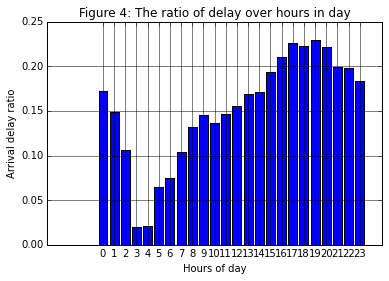

In [19]:
# plot a bar chart

plt.xlabel("Hours of day")
plt.ylabel("Arrival delay ratio")
plt.title('Figure 4: The ratio of delay over hours in day')
plt.grid(True,which="both",ls="-")
# plot bar chart
plt.bar( pdf_delay_ratio_per_hour[0], pdf_delay_ratio_per_hour[1], align='center')
plt.xticks(pdf_delay_ratio_per_hour[0])
plt.show()


<div class="comment">
During the day, the more the time flies, the more the delay ratio increases. It begins to decrease with the evening (6PM), since the utilization decreases too. Finally, the delay ratio has totally dropped during the night (3AM) since there is far less traffic during the night and will increase again with the start of the busy period (5AM).
</div>

<div class='anchor' ></div>
#### Question 5.2

You will realize that saying "at 4 A.M. there is a very low chance of a flight being delayed" is not giving you a full picture of the situation. Indeed, it might be true that there is very little probability for a early flight to be delayed, but if it does, the delay might be huge, like 6 hours! 

Then, the question is: which hours of the day are characterized by the largest delay? Plot a Bar chart and explain it.

     0         1
0    0  4.865693
1    1  2.490499
2    2  0.730665
3    3 -2.981707
4    4 -1.581560
5    5  0.189950
6    6  0.371184
7    7  1.655223
8    8  2.746347
9    9  3.286477
10  10  3.414340
11  11  4.020322
12  12  4.425600
13  13  5.163527
14  14  5.775829
15  15  7.212062
16  16  8.392585
17  17  9.218440
18  18  9.411491
19  19  9.777354
20  20  9.766614
21  21  7.777679
22  22  7.705891
23  23  5.709251


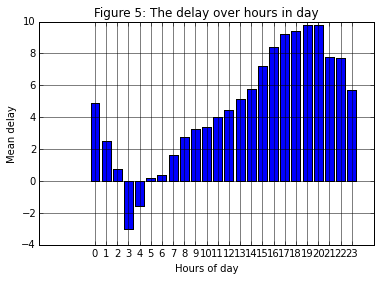

In [20]:
mean_delay_per_hour = statistic_delay_hour.agg(
    (func.mean('arrival_delay')).alias('mean_delay')
)
    
mean_delay_per_hour = (
    mean_delay_per_hour
        .orderBy('hour')
        .select(['hour','mean_delay'])
    )
    
pdf_mean_delay_per_hour = pd.DataFrame(data=mean_delay_per_hour.take(24))
print(pdf_mean_delay_per_hour)

plt.xlabel("Hours of day")
plt.ylabel("Mean delay")
plt.title('Figure 5: The delay over hours in day')
plt.grid(True,which="both",ls="-")
# plot bar chart
plt.bar( pdf_mean_delay_per_hour[0], pdf_mean_delay_per_hour[1], align='center')
plt.xticks(pdf_mean_delay_per_hour[0])
plt.show()



<div class="comment">
They manage to catch up on their delay at 3AM and 4AM. This graph show the same behaviour as the previous one.
</div>

With data of year 1994, the flight from 3AM to 4AM often depart earlier than in their schedule. The flights in the morning have less delay then in the afternoon and evening.

So, an attentive student should notice here that we have somehow a problem with the definition of delay! Next, we will improve how to represent and visualize data to overcome this problem.

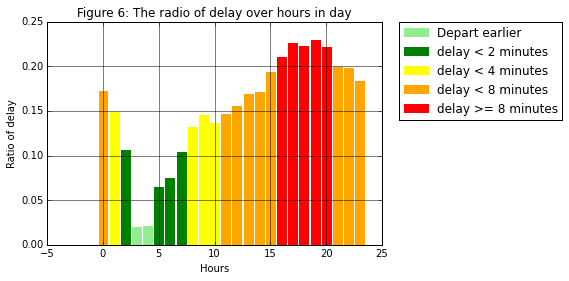

In [21]:
#pdf2 = pd.DataFrame(data=mean_delay_per_hour.collect())
plt.xlabel("Hours")
plt.ylabel("Ratio of delay")
plt.title('Figure 6: The radio of delay over hours in day')
plt.grid(True,which="both",ls="-")
bars = plt.bar(pdf_delay_ratio_per_hour[0], pdf_delay_ratio_per_hour[1], align='center', edgecolor = "black")
for i in range(0, len(bars)):
    color = 'red'
    if pdf_mean_delay_per_hour[1][i] < 0:
        color = 'lightgreen'
    elif pdf_mean_delay_per_hour[1][i] < 2:
        color = 'green'
    elif pdf_mean_delay_per_hour[1][i] < 4:
        color = 'yellow'
    elif pdf_mean_delay_per_hour[1][i] < 8:
        color = 'orange'

    bars[i].set_color(color)
        
patch1 = mpatches.Patch(color='lightgreen', label='Depart earlier')
patch2 = mpatches.Patch(color='green', label='delay < 2 minutes')
patch3 = mpatches.Patch(color='yellow', label='delay < 4 minutes')
patch4 = mpatches.Patch(color='orange', label='delay < 8 minutes')
patch5 = mpatches.Patch(color='red', label='delay >= 8 minutes')

plt.legend(handles=[patch1, patch2, patch3, patch4, patch5], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

In the new figure (Figure 6), we have more information in a single plot. The flights in 3AM to 4AM have very low probability of being delayed, and actually depart ealier than their schedule. In contrast, the flights in the 4PM to 8PM range have higher chances of being delayed: in more than 50% of the cases, the delay is 8 minutes or more.

This example shows us that the way representing results are also important.


<div class='anchor' ></div>
#### Question 5.3
Plot a bar chart to show the percentage of delayed flights over days in a month

     0         1
0    0  4.865693
1    1  2.490499
2    2  0.730665
3    3 -2.981707
4    4 -1.581560
5    5  0.189950
6    6  0.371184
7    7  1.655223
8    8  2.746347
9    9  3.286477
10  10  3.414340
11  11  4.020322
12  12  4.425600
13  13  5.163527
14  14  5.775829
15  15  7.212062
16  16  8.392585
17  17  9.218440
18  18  9.411491
19  19  9.777354
20  20  9.766614
21  21  7.777679
22  22  7.705891
23  23  5.709251


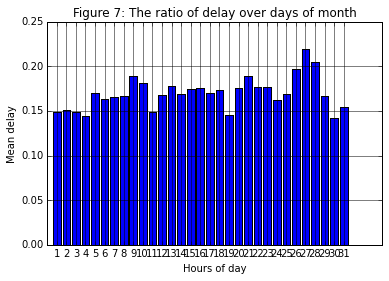

In [22]:
####### The changes of delay ratio over days of month ########
# calculate the delay ratio in each day of month
statistic_day_of_month = (
    df_with_delay
        .groupBy('day_of_month')
        .agg(func.sum('is_delay')/func.count('*')).alias('delay_ratio')
        # order by day_of_month
        .orderBy('day_of_month')
    )

# collect data and plot       
pdf_day_of_month = pd.DataFrame(data=statistic_day_of_month.take(31))
print(pdf_mean_delay_per_hour)

plt.xlabel("Hours of day")
plt.ylabel("Mean delay")
plt.title('Figure 7: The ratio of delay over days of month')
plt.grid(True,which="both",ls="-")
# plot bar chart
plt.bar( pdf_day_of_month[0], pdf_day_of_month[1], align='center')
plt.xticks(pdf_day_of_month[0])
plt.show()

<div class="comment">
From the 26th to the 28th, the delay ratio is slightly higher, but globally there seems to be no strong correlation between delay ratio and day of the week.
</div>

<div class='anchor' ></div>
#### Question 5.4
Plot a bar chart to show the percentage of delayed flights over days in a week

   0         1
0  1  0.163292
1  2  0.153303
2  3  0.181512
3  4  0.197797
4  5  0.194870
5  6  0.141409
6  7  0.156096


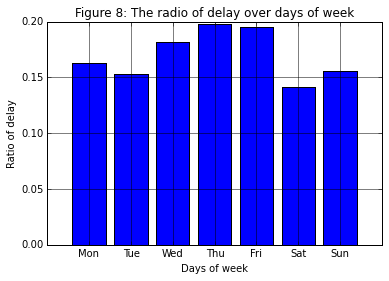

In [28]:
####### The changes of delay ratio over days of week ########
# calculate the delay ratio in each day of week
statistic_day_of_week = (
    df_with_delay
        .groupBy('day_of_week')
        .agg(func.sum('is_delay')/func.count('*')).alias('delay_ratio')
        # order by day_of_week
        .orderBy('day_of_week')
    )
    
# collect data and plot
pdf_day_of_week = pd.DataFrame(data=statistic_day_of_week.take(7))
print(pdf_day_of_week)

plt.xlabel("Days of week")
plt.ylabel("Ratio of delay")
plt.title('Figure 8: The radio of delay over days of week')
plt.grid(True,which="both",ls="-")
map_int_into_day = { 1:"Mon", 2:"Tue", 3:"Wed", 4:"Thu", 5:"Fri", 6:"Sat", 7:"Sun" }
day_of_week_label = pdf_day_of_week[0].map(lambda i: map_int_into_day[i])

# plot bar chart
plt.bar( range(1,8), pdf_day_of_week[1], align='center')
plt.xticks(pdf_day_of_week[0],day_of_week_label)
plt.show()

<div class="comment">
We saw that the traffic was a bit lower on weekends. So is the delay ratio.
</div>

<div class='anchor' ></div>
#### Question 5.5
Plot a bar chart to show the percentage of delayed flights over months in a year

     0         1
0    1  0.242754
1    2  0.214235
2    3  0.160428
3    4  0.161888
4    5  0.118353
5    6  0.173280
6    7  0.193987
7    8  0.154600
8    9  0.115162
9   10  0.134264
10  11  0.184295
11  12  0.195617


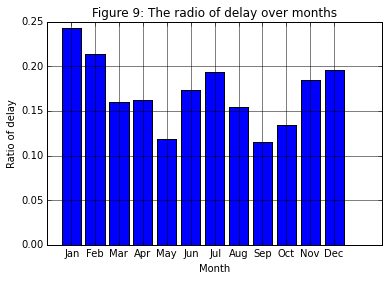

In [30]:
####### The changes of delay ratio over months ########
# calculate the delay ratio in month
statistic_month = (
    df_with_delay
        .groupBy('month')
        .agg(func.sum('is_delay')/func.count('*')).alias('delay_ratio')
        # order by day_of_week
        .orderBy('month')
    )
    
# collect data and plot
pdf_month = pd.DataFrame(data=statistic_month.take(12))
print(pdf_month)

plt.xlabel("Month")
plt.ylabel("Ratio of delay")
plt.title('Figure 9: The radio of delay over months')
plt.grid(True,which="both",ls="-")
map_int_into_month = { 1:"Jan", 2:"Feb", 3:"Mar", 4:"Apr", 5:"May", 6:"Jun",\
                    7:"Jul", 8:"Aug", 9:"Sep", 10:"Oct", 11:"Nov", 12:"Dec" }
month_label = pdf_month[0].map(lambda i: map_int_into_month[i])

# plot bar chart
plt.bar( range(1,13), pdf_month[1], align='center')
plt.xticks(pdf_month[0],month_label)
plt.show()

<div class="comment">
We expected a peak during the summer holidays and for Christmas and New Year (at question 4.1) : we have them. But the general shape of the graph is not the same. For instance, we expected a very low ratio of delay in February due to the fact that the traffic is very low; it's not the case.
</div>

We are ready now to draw some observations from our data, even if we have only looked at data coming from a year worth of flights:

- The probability for a flight to be delayed is low at the beginning or at the very end of a given months
- Flights on two first weekdays and on the weekend are less likely to be delayed
- May and September are very good months for travelling, as the probability of delay is low (remember we're working on US data. Do you think this is also true in France?)

Putting things together, we can have a global picture of the whole year!

In [31]:
df_with_delay = df.withColumn('is_delay', when(df["arrival_delay"] >= 15, 1).otherwise(0))
statistic_day = df_with_delay.groupBy(['year','month', 'day_of_month', 'day_of_week'])\
    .agg((func.sum('is_delay')/func.count('*')).alias('delay_ratio'))

# assume that w..e do statistic on year 1994
statistic_day = statistic_day\
    .orderBy('year', 'month', 'day_of_month', 'day_of_week')
pdf = pd.DataFrame(data=statistic_day.collect())

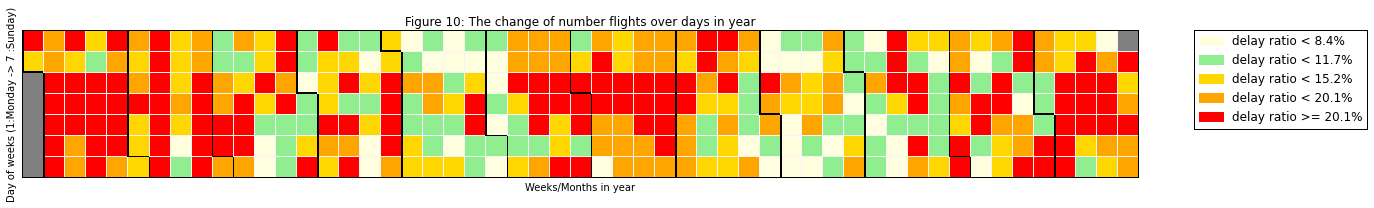

In [33]:
Monfig = plt.figure(figsize=(20,10))                                                             
ax = Monfig.add_subplot(1,1,1)     
plt.xlabel("Weeks/Months in year")
plt.ylabel("Day of weeks (1:Monday -> 7 :Sunday)")
plt.title('Figure 10: The change of number flights over days in year')
  
rec_size = 0.3
from matplotlib.patches import Rectangle
import datetime
num_days = len(pdf[0])
ax.patch.set_facecolor('gray')
ax.set_aspect('equal', 'box')
ax.xaxis.set_major_locator(plt.NullLocator())
ax.yaxis.set_major_locator(plt.NullLocator())

for i in range(0, num_days):
    # extract information from the result
    year = pdf[0][i]
    month = pdf[1][i]
    day_of_month = pdf[2][i]
    day_of_week = pdf[3][i]
    day_of_year= datetime.date(year=year, month=month, day=day_of_month).timetuple()
    week_of_year = datetime.date(year=year, month=month, day=day_of_month).isocalendar()[1]
    
    # dealing with the week of the previous year
    if week_of_year == 52 and month == 1:
        week_of_year = 0
        
    # the coordinate of a day in graph
    X = week_of_year*rec_size
    Y = day_of_week*rec_size
    
    # use different colors to show the delay ratio
    color = 'white'
    if pdf[4][i] <= 0.084:
        color = 'lightyellow'
    elif pdf[4][i] <= 0.117:
        color = 'lightgreen'
    elif pdf[4][i] <= 0.152:
        color = 'gold'
    elif pdf[4][i] <= 0.201:
        color = 'orange'
    else:
        color = 'red'
    rect = plt.Rectangle((X - rec_size/2.0, Y - rec_size/2.0), rec_size, rec_size,
                      alpha=1, facecolor=color, edgecolor='whitesmoke')

    ax.add_patch(rect)
    
    # drawing boders to separate months
    if day_of_month <= 7:
        rect2 = plt.Rectangle((X -rec_size/2.0, Y - rec_size/2.0), 0.01, rec_size,
                      alpha=1, facecolor='black')
        ax.add_patch(rect2)
    if day_of_month == 1:
        rect2 = plt.Rectangle((X - rec_size/2.0, Y - rec_size/2.0), rec_size, 0.01,
                      alpha=1, facecolor='black')
        ax.add_patch(rect2)
ax.autoscale_view()

patch1 = mpatches.Patch(color='lightyellow', label='delay ratio < 8.4%')
patch2 = mpatches.Patch(color='lightgreen', label='delay ratio < 11.7%')
patch3 = mpatches.Patch(color='gold', label='delay ratio < 15.2%')
patch4 = mpatches.Patch(color='orange', label='delay ratio < 20.1%')
patch5 = mpatches.Patch(color='red', label='delay ratio >= 20.1%')

plt.legend(handles=[patch1, patch2, patch3, patch4, patch5], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

<div class='anchor' ></div>
#### Question 5.6
Explain figure 10.

<div class="answer">
Each column is a week of the year; each block is a month; each line is a day of the week. Thus we have a representation of the delay ratio over all the days of the year 1994. 


Generally, busy parts are centered in the blocks such that we can conclude that the high delay ratio are in the middle of the months and in the middle of the weeks. 


By the way, we can also notice that May and September are clearly the best months in terms of delay ratio.


We can also study the variability of the delay ratio through months : for instance April or October are months where the delay will be quite hard to predic whereas July or January are not "surprising" months.
</div>

<div class='anchor' ></div>
#### Question 5.7

What is the delay probability for the top 20 busiest airports?
By drawing the flight volume of each airport and the associated delay probability in a single plot, we can observe the relaltionship between aiports, number of flights and the delay.

HINT: Function `<df_colum>.isin(<list>)` helps checking whether a value in column belongs to a list.

In [37]:
####### The delay ratio of the top 20 busiest airports ########
K = 20

# extract top_20_airports from stat_airport_traffic
top_20_airports = [item[0] for item in stat_airport_traffic.take(K)]

# select the statistic of source airports
statistic_ratio_delay_airport = (
    df_with_delay
        # select only flights that depart from one of top 20 airports
        .filter(df_with_delay.src_airport.isin(top_20_airports))
        # group by source airport
        .groupBy('src_airport')
        #  calculate the delay ratio
        .agg(func.sum('is_delay')/func.count('*')).alias('delay_ratio')
        # sort by name of airport
        .orderBy(['src_airport'])
    )
statistic_ratio_delay_airport.show(20)

+-----------+--------------------------+
|src_airport|(sum(is_delay) / count(1))|
+-----------+--------------------------+
|        ATL|       0.21205403501801467|
|        BOS|       0.20337767149902855|
|        CLT|       0.22251161209048542|
|        DCA|        0.1599864322460286|
|        DEN|       0.20354670607451195|
|        DFW|       0.22524719636014578|
|        DTW|       0.17069213736050923|
|        EWR|       0.26439606741573035|
|        IAH|        0.1660171622737133|
|        LAS|       0.17218759213241797|
|        LAX|       0.16996104082244257|
|        LGA|       0.19028312259483232|
|        MCO|         0.167725622406639|
|        MSP|       0.15585690866890653|
|        ORD|       0.16788302771286917|
|        PHL|       0.21505583159694394|
|        PHX|       0.17194317278139576|
|        PIT|       0.21883994899867915|
|        SFO|       0.16634949633351095|
|        STL|       0.18877507271995725|
+-----------+--------------------------+



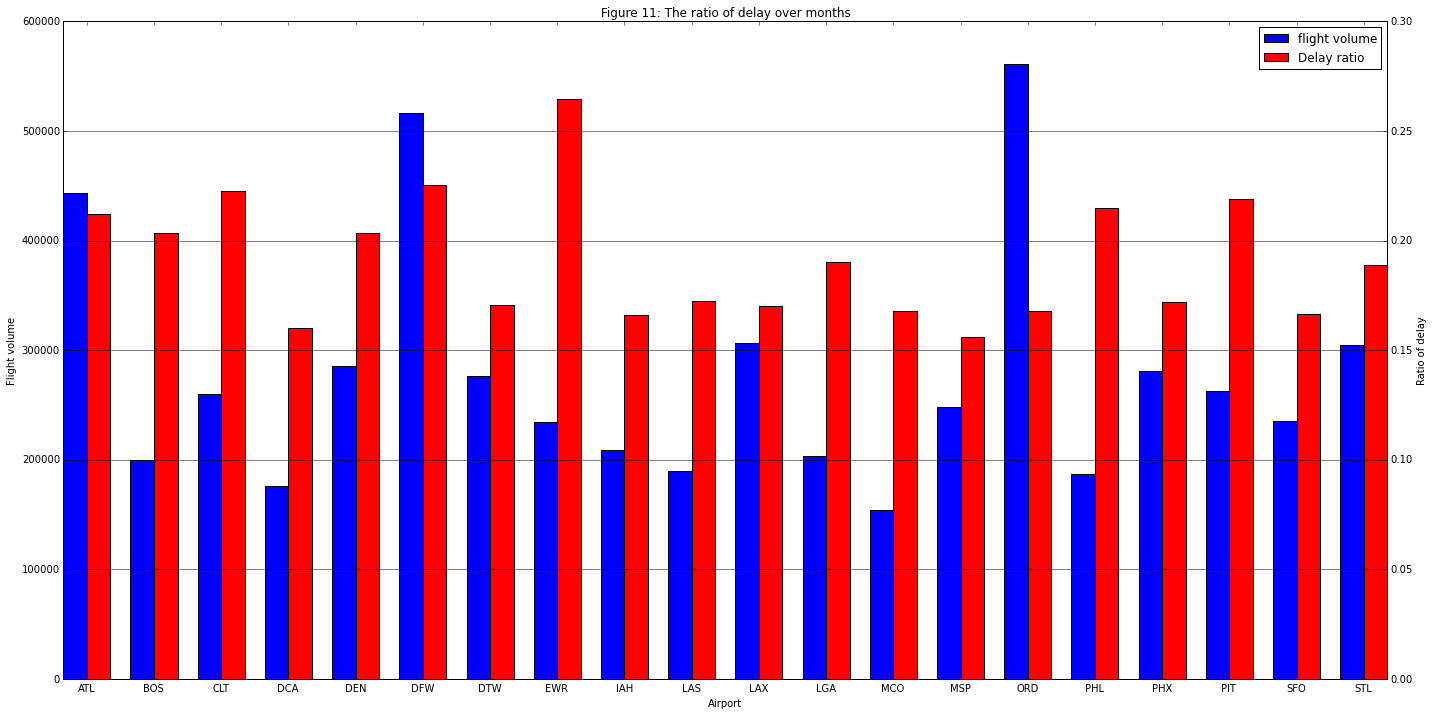

In [39]:
# collect data and plot
pdf_ratio_delay_airport = pd.DataFrame(data=statistic_ratio_delay_airport.collect())
pdf_top_20_airport_volume = pd.DataFrame(data=stat_airport_traffic.take(K), columns=['src_airport', 'total'])
pdf_top_20_airport_volume = pdf_top_20_airport_volume.sort_values(by='src_airport')
#print(pdf_top_20_airport_volume)
index = np.arange(len(top_20_airports))
bar_width = 0.35
opacity = 0.4


fig = plt.figure(figsize=(20,10))                                                             
ax = fig.add_subplot(1,1,1)

ax2 = ax.twinx()
plt.axis('normal')
ax.set_xlabel("Airport")
ax.set_ylabel("Flight volume")
ax2.set_ylabel("Ratio of delay")
plt.xticks(index + bar_width, sorted(top_20_airports))
plt.title('Figure 11: The ratio of delay over months')
plt.grid(True,which="both",ls="-")
bar = ax.bar(index, pdf_top_20_airport_volume['total'], 
        bar_width, color='b', 
        label='flight volume')
bar2 = ax2.bar(index + 1.5*bar_width, pdf_ratio_delay_airport[1], bar_width, 
       align='center', color='r', 
       label='Delay ratio')

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

plt.tight_layout()
plt.show()

<div class="comment">
We feel that the correlation betzeen flight volume and delay ratio is not very high : indeed we can have as airports which will tend to have high delay ratio whereas they are not so used (EWR), as ones which are very busy but have quite low delays (ORD).
</div>

<div class='anchor' ></div>
#### Question 5.8
What is the percentage of delayed flights which belong to one of the top 20 busiest carriers? Comment the figure!

In [42]:
K = 10

# extract top_10_carriers from stat_carrier
top_20_carriers = [item[0] for item in stat_carrier.take(K)]

statistic_ratio_delay_carrier = (
    df_with_delay
        # select only flights that belong from one of top 20 carriers
        .filter(df_with_delay.src_airport.isin(top_20_airports))
        # group by carrier
        .groupBy('carrier')
        #  calculate the delay ratio
        .agg(func.sum('is_delay')/func.count('*')).alias('delay_ratio')
        # sort by carrier
        .orderBy(['carrier'])
    )
statistic_ratio_delay_carrier.show(10)


+-------+--------------------------+
|carrier|(sum(is_delay) / count(1))|
+-------+--------------------------+
|     AA|        0.1969286665859271|
|     AS|        0.1621853898096992|
|     CO|        0.2156835421107738|
|     DL|        0.1934384379204471|
|     HP|       0.20807310800881704|
|     NW|        0.1545543268338614|
|     TW|       0.19830546123821916|
|     UA|       0.18143717634561762|
|     US|       0.21276221821028582|
|     WN|       0.15502671324360423|
+-------+--------------------------+



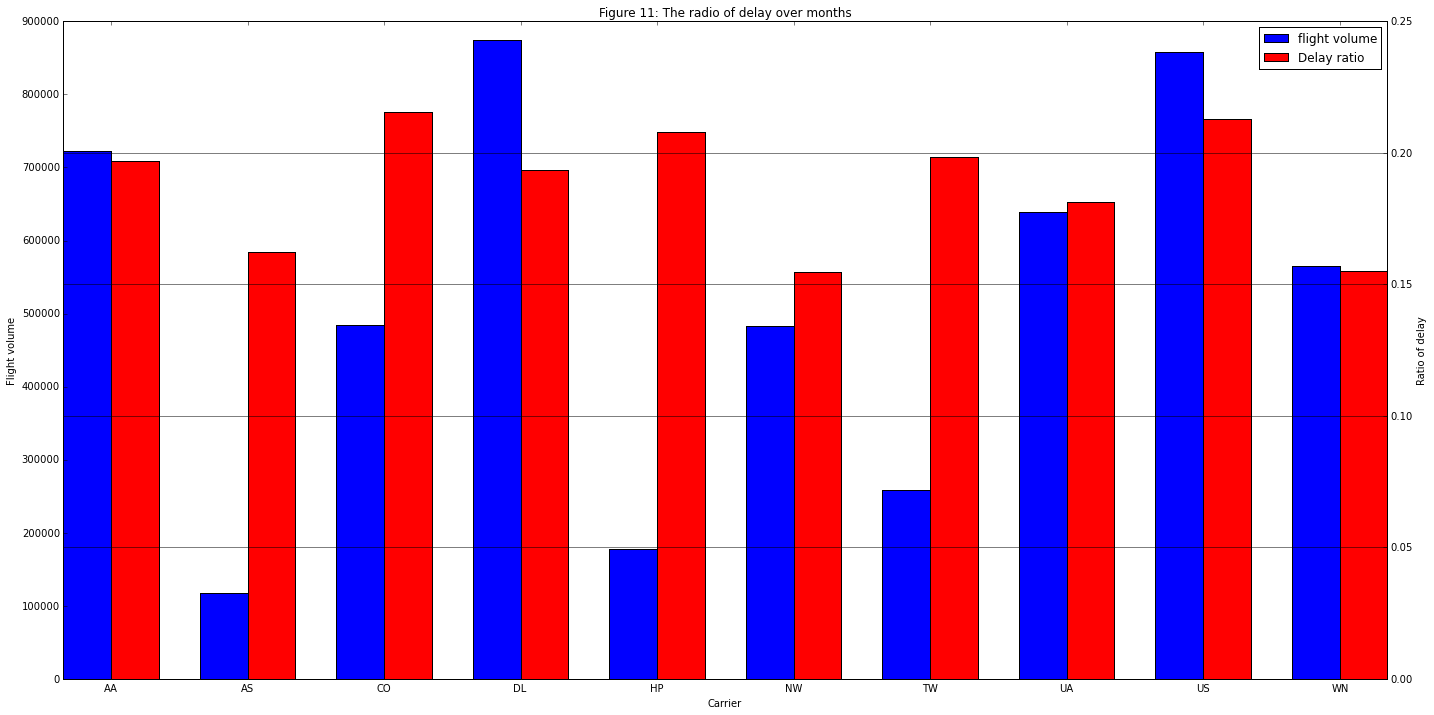

In [43]:
# collect data and plot
pdf_ratio_delay_carrier = pd.DataFrame(data=statistic_ratio_delay_carrier.collect())
pdf_top_20_carrier_volume = pd.DataFrame(data=stat_carrier.take(K), columns=['carrier', 'count'])
pdf_top_20_carrier_volume = pdf_top_20_carrier_volume.sort_values(by='carrier')
#print(pdf_top_20_carrier_volume)
top_20_carriers.sort()
index = np.arange(len(top_20_carriers))
bar_width = 0.35
opacity = 0.4


fig = plt.figure(figsize=(20,10))                                                             
ax = fig.add_subplot(1,1,1)
count
ax2 = ax.twinx()
plt.axis('normal')
ax.set_xlabel("Carrier")
ax.set_ylabel("Flight volume")
ax2.set_ylabel("Ratio of delay")
plt.xticks(index + bar_width, top_20_carriers)

plt.title('Figure 11: The radio of delay over months')
plt.grid(True,which="both",ls="-")
bar = ax.bar(index, pdf_top_20_carrier_volume['count'], 
        bar_width, color='b', 
        label='flight volume')
bar2 = ax2.bar(index + 1.5*bar_width, pdf_ratio_delay_carrier[1], bar_width, 
       align='center', color='r', 
       label='Delay ratio')

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

plt.tight_layout()
plt.show()

<div class="comment">
Globally the variation of the delay ratio given the carrier is low : those delay ratios are quite uniform. However, these variations follow a little the flight volume's variations.
</div>

# 4. Building a model of our data
Now that we have a good grasp on our data and its features, we will focus on how build a statistic model. Note that the features we can decide to use, to train our model, can be put in two groups:

- **Explicit features**: these are features that are present in the original data, or that can be built using additional data sources such as `weather` (for example querying a public API)
- **Implicit features**: these are the features that are inferred from other features such as `is_weekend`, `is_holiday`, `season`, `in_winter`,...

In this notebook, we will focus on the following predictors: `year`, `month`, `day_of_month`, `day_of_week`, `scheduled_departure_time`, `scheduled_arrival_time`, `carrier`, `is_weekend`, `distance`, `src_airport`, `dest_airport`. Among them, `is_weekend` is an implicit feature. The rest are explicit features.

The target feature is `arrival_delay`. 

Currently, MLLIB only supports building models from RDDs. It is important to read well the documentation and the MLLib API, to make sure to use the algorithms in an appropriate manner:

- MLLIB supports both categorical and numerical features. However, for each categorical feature, we have to indicate how many distinct values they can take
- Each training record must be a ```LabelledPoint```. This datastructure has 2 components: ```label``` and ```predictor vector```. ```label``` is the value of target feature in the current record. ```predictor vector``` is a vector of values of type ```Double```. As such, we need to map each value of each categorical feature to a number. In this project, we choose a naïve approach: map each value to an unique index. 
- MLLIB uses a binning technique to find the split point (the predicate in each tree node). In particular, it divides the domain of numerical features into ```maxBins``` bins (32 by default). With categorical features, each distinct value fits in its own bin. **IMPORTANT:** MLLIB requires that no categorical feature have more than `maxBins` distinct values.
- We fill up the missing values in each **categorical** feature with it's most common value. The missing values of a **numerical** feature are also replaced by the most common value (however, in some cases, a more sensible approach would be to use the median of this kind of feature).


## 4.1 Mapping values of each categorical feature to indices

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

<div class='anchor' ></div>
### Question 6 

Among the selected features, `src_aiport`, `dest_airport`, `carrier` and `distance` have missing values. Besides, the first three of them are categorical features. That means, in order to use them as input features of MLLIB, the values of these features must be numberical. We can use a naïve approach: map each value of each feature to an unique index.

#### Question 6.1
Calculate the frequency of each source aiport in the data and build a dictionary that maps each of them to a unique index.

Note: we sort the airports by their frequency in descending order, so that we can easily take the most common airport(s) by taking the first element(s) in the result.

In [14]:
# select distinct source airports and map values to index
# sort the airport by their frequency descending
# so the most common aiport will be on the top
stat_src = (
    df
        .groupBy('src_airport')
        .agg(func.count('*').alias('count'))
        .orderBy(desc('count'))
    )
#stat_src.show()
# extract the airport names from stat_src
src_airports = [item[0] for item in stat_src.collect()]

num_src_airports = len(src_airports )
src_airports_idx = range(0, num_src_airports)
map_src_airport_to_index = dict(zip(src_airports, src_airports_idx))

# test the dictionary
print(map_src_airport_to_index['ORD'])
print(map_src_airport_to_index['ATL'])
#print(map_src_airport_to_index)

0
2


<div class='anchor' ></div>
#### Question 6.2
Calculate the frequency of each destination aiport in the data and build a dictionary that maps each of them to a unique index.

In [15]:
# select distinct destination airports and map values to index
# sort the airport by their frequency descending
# so the most common aiport will be on the top
stat_dest = (
    df
        .groupBy('dest_airport')
        .agg(func.count('*').alias('count'))
        .orderBy(desc('count'))
    )
#stat_dest.show()
dest_airports = [item[0] for item in stat_dest.collect()]

num_dest_airports = len(dest_airports )
dest_airports_idx = range(0, num_dest_airports)
map_dest_airport_to_index = dict(zip(dest_airports, dest_airports_idx))

# test the dictionary
print(map_dest_airport_to_index['ORD'])
print(map_dest_airport_to_index['ATL'])
#print(map_dest_airport_to_index)

0
2


<div class='anchor' ></div>
#### Question 6.3
Calculate the frequency of each carrier in the data and build a dictionary that maps each of them to a unique index.

In [16]:
# select distinct carriers and map values to index
# sort carriers by their frequency descending
# so the most common aiport will be on the top
stat_carrier = (
    df
        .groupBy('carrier')
        .agg(func.count('*').alias('count'))
        .orderBy(desc('count'))
    )
stat_carrier.show()
carrier = [item[0] for item in stat_carrier.collect()]

num_carrier = len(carrier)
carrier_idx = range(0, num_carrier)
map_carriers_to_index = dict(zip(carrier, carrier_idx))
print(map_carriers_to_index)

+-------+------+
|carrier| count|
+-------+------+
|     DL|874526|
|     US|857906|
|     AA|722277|
|     UA|638750|
|     WN|565426|
|     CO|484834|
|     NW|482798|
|     TW|258205|
|     HP|177851|
|     AS|117475|
+-------+------+

{'HP': 8, 'WN': 4, 'US': 1, 'NW': 6, 'DL': 0, 'CO': 5, 'UA': 3, 'AS': 9, 'TW': 7, 'AA': 2}


## 4.2 Calculating the most common value of each feature
We use a simple strategy for filling in the missing values : replacing them with the most common value of the corresponding feature.

**IMPORTANT NOTE:** features like ```month```, ```day_of_month```, etc... can be treated as numerical features in general. However, when it comes to build the model, it is much easier considering them as categorical features. In this case, to compute the most common value for such categorical features, we simply use the frequency of occurrence of each `label`, and chose the most frequent.

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

<div class='anchor' ></div>
### Question 7
In the previous question, when constructing the dictionary for categorical features, we also sort their statistical information in a such way that the most common value of each feature are placed on the top.

Note that, feature `is_weekend` has the most common value set to `0` (that is, `no` the day is not a weekend).

<div class='anchor' ></div>
#### Question 7.1
Find the most common value of feature `month` in data.



In [17]:
the_most_common_month = (
    df
        .groupBy('month')
        .agg(func.count('*').alias('count'))
        .orderBy(desc('count'))
    ).first()[0]

print("The most common month:", the_most_common_month)

The most common month: 8


<div class='anchor' ></div>
#### Question 7.2
Find the most common value of features `day_of_month` and `day_of_week`.

In [18]:
the_most_common_day_of_month = (
    df
        .groupBy('day_of_month')
        .agg(func.count('*').alias('count'))
        .orderBy(desc('count'))
    ).first()[0]

the_most_common_day_of_week = (
    df
        .groupBy('day_of_week')
        .agg(func.count('*').alias('count'))
        .orderBy(desc('count'))
    ).first()[0]

print("The most common day of month:", the_most_common_day_of_month)
print("The most common day of week:", the_most_common_day_of_week)

The most common day of month: 11
The most common day of week: 3


<div class='anchor' ></div>
#### Question 7.3
Find the most common value of features `scheduled_departure_time` and `scheduled_arrival_time`.

In [19]:
the_most_common_s_departure_time = (
    df
        .groupBy('scheduled_departure_time')
        .agg(func.count('*').alias('count'))
        .orderBy(desc('count'))
    ).first()[0]

the_most_common_s_arrival_time = (
    df
        .groupBy('scheduled_arrival_time')
        .agg(func.count('*').alias('count'))
        .orderBy(desc('count'))
    ).first()[0]

print("The most common scheduled departure time:", the_most_common_s_departure_time)
print("The most common scheduled arrival time:", the_most_common_s_arrival_time)

The most common scheduled departure time: 700
The most common scheduled arrival time: 1915


<div class='anchor' ></div>
#### Question 7.4
Calculate the mean of distance in the data. This value will be used to fill in the missing values of feature `distance` later.

In [20]:
# calculate mean distance
mean_distance =  (
    df
        .agg((func.sum('distance')/func.count('*')))
    ).first()[0]

print("mean distance:", mean_distance)

mean distance: 667.7687320658033


<div class='anchor' ></div>
#### Question 7.5
Calculate the mean of arrival delay.

In [21]:
# calculate mean arrival delay
mean_arrival_delay = (
    df
        .agg((func.sum('arrival_delay')/func.count('*')))
    ).first()[0]

print("mean arrival delay:", mean_arrival_delay)

mean arrival delay: 5.576300451269949


As known from section 3.4, there are 225 different origin airports and 225 different destination airports, more than the number of bins in default configuration. So, we must set `maxBins` >= 225.

## 4.3 Preparing training data and testing data
Recall, in this project we focus on decision trees. One way to think about our task is that we want to predict the unknown `arrival_delay` as a function combining several features, that is:

`arrival_delay = f(year, month, day_of_month, day_of_week, scheduled_departure_time, scheduled_arrival_time, carrier, src_airport, dest_airport, distance, is_weekend)`

When categorical features contain corrupt data (e.g., missing values), we proceed by replacing corrupt information with the most common value for the feature. For numerical features, in general, we use the same approach as for categorical features; in some cases, we repair corrupt data using the mean value of the distribution for numerical features (e.g., we found the mean for `delay` and `distance`, by answering questions above).

The original data is split randomly into two parts with ratios 70% for **training** and 30% for **testing**.

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

<div class='anchor' ></div>
### Question 8
- Replace the missing values of each feature in our data by the corresponding most common value or mean.
- Divide data into two parts: 70% for training and 30% for testing

In [22]:
from pyspark.mllib.tree import DecisionTree, DecisionTreeModel
from pyspark.mllib.util import MLUtils
from pyspark.mllib.regression import LabeledPoint


def is_valid(value):
    return value != "NA" and len(value) > 0

data = cleaned_data\
    .map(lambda line: line.split(','))\
    .map(lambda values: 
        LabeledPoint( 
            int(values[14]) if is_valid(values[14]) else mean_arrival_delay, # arrival delay
            [
                int(values[0]), # year
                int(values[1]) if is_valid(values[1]) else most_common_month, # month
                int(values[2]) if is_valid(values[2]) else the_most_common_day_of_month, # day of month
                int(values[3]) if is_valid(values[3]) else the_most_common_day_of_week, # day of week
                int(values[5]) if is_valid(values[5]) else the_most_common_s_departure_time , # scheduled departure time
                int(values[7]) if is_valid(values[7]) else the_most_common_s_arrival_time, # scheduled arrival time
                # if the value is valid, map it to the corresponding index
                # otherwise, use the most common value
                map_carriers_to_index[values[8]] if is_valid(values[8]) \
                    else map_carriers_to_index[carriers[0]], # carrier
                map_src_airport_to_index[values[16]], # src_airport
                map_dest_airport_to_index[values[17]], # destination_airport
                int(values[18]) if is_valid(values[18]) else mean_distance, # distance
                1 if is_valid(values[3]) and int(values[3]) >= 6 else 0, # is_weekend
            ]
        )
    )

# Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = data.randomSplit(weights=[0.7, 0.3])

trainingData = trainingData.cache()
testData = testData.cache()

## 5.4 Building a decision tree model

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

<div class='anchor' ></div>
### Question 9
We can train a decision model by using function `DecisionTree.trainRegressor(<training_data>, categoricalFeaturesInfo=<categorical_info>, impurity=<impurity_function>,  maxDepth=<max_depth>, maxBins=<max_bins>)`.

Where,

* `training_data` : the data used for training
* `categorical_info` : a dictionary that maps the index of each categorical features to its number of distince values
* `impurity_function` : the function that is used to calculate impurity of data in order to select the best split
* `max_depth`: the maximum depth of the tree
* `max_bins`: the maximum number of bins that the algorithm will divide on each feature. Note that, `max_bins` can not smaller than the number distinct values of every categorical features.

Complete the code below to train a decision tree model.


In [23]:

# declare information of categorical features
# format:  feature_index : number_distinct_values
categorical_info = {6 : num_carrier, 7: num_src_airports, 8: num_dest_airports, 10: 2}

# Train a DecisionTree model.
model = DecisionTree.trainRegressor(trainingData, 
                                    categoricalFeaturesInfo=categorical_info,
                                    impurity='variance', 
                                    maxDepth=12,
                                    maxBins=255)

## 5.5 Testing the decision tree model

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

<div class='anchor' ></div>
### Question 10
#### Question 10.1
We often use Mean Square Error as a metric to evaluate the quality of a tree model. Complete the code below to calculate the MSE of our trained model.

In [24]:
# Evaluate model on test instances and compute test error
predictions = model.predict(testData.map(lambda x: x.features))
labelsAndPredictions = testData.map(lambda lp: lp.label).zip(predictions)
print(labelsAndPredictions.take(10))
testMSE = labelsAndPredictions.map(
    lambda p: (p[0]-p[1])*(p[0]-p[1])).mean()
print('\nTest Mean Squared Error = ' + str(testMSE))

[(-9.0, 0.6036926084124613), (1.0, -3.6020187952388856), (5.576300451269949, 2.596035803977504), (3.0, 2.596035803977504), (5.0, 2.596035803977504), (2.0, 1.6614055196535955), (-3.0, 6.603351288395376), (-14.0, 1.6614055196535955), (-5.0, -0.5564782103710079), (-3.0, -1.2351885398038098)]

Test Mean Squared Error = 489.89434257411165


In [25]:
print(predictions.mean())

5.670296208217788


<div class='anchor' ></div>
### Question 10.2
Comment the results you have obtained. Is the MSE value you get from a decision tree indicating that our statistical model is very good in predicting airplane delays? Use your own words to describe and interpret the value you obtained for the MSE.

<div class="answer">
The prediction is good in mean but is unable to deal with the variability of the data (noise ?), which give us a quite big MSE. Indeed, we can predict the small delays but not important ones.
</div>

## 5.6 Building random decision forest model (or random forest)
Next, we use MLLib to build a more powerful model: random forests. In what follows, use the same predictors defined and computed above to build a decision tree, but this time use them to build a random decision forest.

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

<div class='anchor' ></div>
### Question 11
Train a random decision forest model and evaluate its quality using MSE metric. Compare to decision tree model and comment the results. Similarly to question 10.2, comment with your own words the MSE value you have obtained.

In [136]:
from pyspark.mllib.tree import RandomForest, RandomForestModel

# Train a RandomForest model.
forest_model = RandomForest.trainRegressor(trainingData, categoricalFeaturesInfo=categorical_info,
                                    numTrees=10, impurity='variance', maxDepth=12, maxBins=255)

forest_predictions = forest_model.predict(testData.map(lambda x: x.features))
forest_labelsAndPredictions = testData.map(lambda lp: lp.label).zip(forest_predictions)
print(forest_labelsAndPredictions.take(10))
forest_testMSE = forest_labelsAndPredictions.map(
    lambda p: (p[0]-p[1])*(p[0]-p[1])).mean()
print('\nTest Mean Squared Error = ' + str(forest_testMSE))

[(20.0, 4.064087173403287), (88.0, 4.864393215532095), (21.0, 4.864393215532095), (5.576300451269949, 4.17332607291071), (2.0, 3.720155115533955), (-8.0, 3.3730200307819027), (-16.0, 4.17332607291071), (12.0, 4.17332607291071), (-2.0, 3.1925391370019836), (3.0, 3.324350356918901)]

Test Mean Squared Error = 490.6969230164904


<div class="comment">
The MSE has not changed that much.
</div>

## 5.7 Parameter tuning
In this lecture, we used `maxDepth=12`, `maxBins=255`, `numTrees=10`. Next, we are going to explore the meta-paramter space a little bit.

For more information about parameter tunning, please read the documentation of [MLLIB](http://spark.apache.org/docs/latest/mllib-decision-tree.html#tunable-parameters)

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

<div class='anchor' ></div>

### Question 12
Train the random forest model using different parameters, to understand their impact on the main performance metric we have used here, that is the MSE. For example, you can try a similar approach to that presented in the Notebook on reccommender systems, that is using nested for loops.

**NOTE:** be careful when selecting parameters as some might imply very long training times, or eventually, the typical memory problems that affect Spark!

In [143]:
for depth in [10, 15]:
    for trees in [10, 20]:
        for Mbin in [255, 511]:
            # Train a RandomForest model.
            test_forest_model = RandomForest.trainRegressor(trainingData, categoricalFeaturesInfo=categorical_info,
                                        numTrees=trees, impurity='variance', maxDepth=depth, maxBins=Mbin)

            test_forest_predictions = test_forest_model.predict(testData.map(lambda x: x.features))
            test_forest_labelsAndPredictions = testData.map(lambda lp: lp.label).zip(test_forest_predictions)
            test_forest_testMSE = test_forest_labelsAndPredictions.map(
                lambda p: (p[0]-p[1])*(p[0]-p[1])).mean()
            print('parameters : ' + str(depth) + ' , ' + str(trees) + ' , ' + str(Mbin) 
                  + '\nTest Mean Squared Error = ' + str(test_forest_testMSE))

parameters : 10 , 10 , 255
Test Mean Squared Error = 504.55895773364216
parameters : 10 , 10 , 511
Test Mean Squared Error = 502.8572490502918
parameters : 10 , 20 , 255
Test Mean Squared Error = 504.0751671864841
parameters : 10 , 20 , 511
Test Mean Squared Error = 502.8290864135344
parameters : 15 , 10 , 255
Test Mean Squared Error = 465.00376584785664
parameters : 15 , 10 , 511
Test Mean Squared Error = 467.45952011281685
parameters : 15 , 20 , 255
Test Mean Squared Error = 461.63481299945937
parameters : 15 , 20 , 511
Test Mean Squared Error = 463.04663752122053


parameters : 10 , 10 , 255
Test Mean Squared Error = 504.55895773364216
parameters : 10 , 10 , 511
Test Mean Squared Error = 502.8572490502918
parameters : 10 , 20 , 255
Test Mean Squared Error = 504.0751671864841
parameters : 10 , 20 , 511
Test Mean Squared Error = 502.8290864135344
parameters : 15 , 10 , 255
Test Mean Squared Error = 465.00376584785664
parameters : 15 , 10 , 511
Test Mean Squared Error = 467.45952011281685
parameters : 15 , 20 , 255
Test Mean Squared Error = 461.63481299945937
parameters : 15 , 20 , 511
Test Mean Squared Error = 463.04663752122053

<div class="comment">
Changing the number of tree doesn't change efficiently the MSE. Changing maxBins doesn't improve anything.
The only influent parameter is the depth of the trees.
</div>

In [ ]:
for depth in [10, 15, 30, 50]:
    # Train a RandomForest model.
    test_forest_model = RandomForest.trainRegressor(trainingData, categoricalFeaturesInfo=categorical_info,
        numTrees=10, impurity='variance', maxDepth=depth, maxBins=255)

    test_forest_predictions = test_forest_model.predict(testData.map(lambda x: x.features))
    test_forest_labelsAndPredictions = testData.map(lambda lp: lp.label).zip(test_forest_predictions)
    test_forest_testMSE = test_forest_labelsAndPredictions.map(
        lambda p: (p[0]-p[1])*(p[0]-p[1])).mean()
    print('parameters : ' + str(depth) + ' , ' + str(trees) + ' , ' + str(Mbin) 
        + '\nTest Mean Squared Error = ' + str(test_forest_testMSE))

# 6. Addition (bonus) questions
As you may have noticed, the performance of our statistical models is somehow questionable! What are we missing here? Why is that even using state-of-the-art approaches give poor results?

In what follows, we will try to address some of the limitations of the present Notebook, and provide additional data that might help.

## 6.1. Additional data
In the HDFS file system you have used for running the Notebook, you will notice that there are several other years available (in addition to 1994), which could be used to train a statistical model with more data. In the end, we're playing with "Big Data", hence one might think that feeding more training data to the algorithm should help!

## 6.2. Feature selection

You might think that the flight delays do not only depend on the source aiport, destination airport, departure time, etc... as we assumed. They also depend on other features such as the weather, the origin country, the destination city,... To improve the prediction quality, we should consider these features too.

There are some other datasets that related to this usecase:

- Airport IATA Codes to City names and Coordinates mapping: http://stat-computing.org/dataexpo/2009/airports.csv
- Carrier codes to Full name mapping: http://stat-computing.org/dataexpo/2009/carriers.csv
- Information about individual planes: http://stat-computing.org/dataexpo/2009/plane-data.csv
- Weather information: http://www.wunderground.com/weather/api/. You can subscribe for free to the developers API and obtain (at a limited rate) hystorical weather information in many different formats. Also, to get an idea of the kind of information is available, you can use this link: http://www.wunderground.com/history/


![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

<div class='anchor' ></div>

### Question 13
Using the data sources above, select additional feature and repeat the process of defining an appropriate training and test datasets, to evaluate the impact of new features on the performance of the model. Focus first on decision trees, then move to random forests.

> The important thing is to not stop questioning. Curiosity has its own reason for existence. (Albert Einstein)

<div class="note">
Be active ! Ask yourself other questions which help you explore more about this data and try to answer them. Make this notebook be a part of your CV !
</div>

## 6.3. Integration of the additional data

### 6.3.1 Airport IATA Codes to City names and Coordinates mapping



In [9]:
!hadoop fs -put airports.csv /user/group05/

put: `/user/group05/airports.csv': File exists


<div class="note">
The line below is useful to put the .csv on the cluster : no need to run it each time you start to edit the Notebook.
</div>

In [10]:
input_path = "/user/group05/airports.csv"
raw_data = sc.textFile(input_path)



print("number of rows before cleaning:", raw_data.count())

number of rows before cleaning: 3377


In [11]:
# extract the header
header = raw_data.first()

# replace invalid data with NULL and remove header
cleaned_data = (raw_data\
        # filter out the header
        .filter(lambda l: l != header)
        # replace the missing values with empty characters
        .map(lambda l: l.replace('NA', ''))
        )
        
print("number of rows after cleaning:", cleaned_data.count())

number of rows after cleaning: 3376


In [12]:
# Declare the data schema
airports_data_schema = StructType([ \
    #StructField( name, dataType, nullable)
    StructField("iata",                     StringType(), True), \
    StructField("airport",                  StringType(), True), \
    StructField("city",                     StringType(), True), \
    StructField("state",                    StringType(), True), \
    StructField("country",                  StringType(), True), \
    StructField("lat",                      FloatType() , True), \
    StructField("long",                     FloatType() , True)  \

                                  ])

In [13]:
import csv


# convert each line into a tuple of features (columns)
cleaned_data_to_columns = cleaned_data.map(lambda l: list(csv.reader([l]))[0])\
    .map(lambda cols: 
         (
            cols[0]         if cols[0] else None,
            cols[1]         if cols[1] else None,
            cols[2]         if cols[2] else None,
            cols[3]         if cols[3] else None,
            cols[4]         if cols[4] else None,
            float(cols[5])  if cols[5] else None,
            float(cols[6])  if cols[6] else None
         ))

In [14]:
# create dataframe df_airports
df_airports = (sqlContext.createDataFrame(cleaned_data_to_columns, airports_data_schema)\
    .select(['iata', 'airport', 'city', 'state',
            'country','lat', 'long'])\
    .cache())

In [15]:
df_airports.show()

+----+--------------------+------------------+-----+-------+---------+----------+
|iata|             airport|              city|state|country|      lat|      long|
+----+--------------------+------------------+-----+-------+---------+----------+
| 00M|            Thigpen |       Bay Springs|   MS|    USA|31.953764|-89.234505|
| 00R|Livingston Municipal|        Livingston|   TX|    USA|30.685862| -95.01793|
| 00V|         Meadow Lake|  Colorado Springs|   CO|    USA|38.945747|-104.56989|
| 01G|        Perry-Warsaw|             Perry|   NY|    USA| 42.74135| -78.05208|
| 01J|    Hilliard Airpark|          Hilliard|   FL|    USA|30.688013|-81.905945|
| 01M|   Tishomingo County|           Belmont|   MS|    USA|34.491665| -88.20111|
| 02A|         Gragg-Wade |           Clanton|   AL|    USA|32.850487| -86.61145|
| 02C|             Capitol|        Brookfield|   WI|    USA| 43.08751| -88.17787|
| 02G|   Columbiana County|    East Liverpool|   OH|    USA|40.673313|  -80.6414|
| 03D|    Memphi

In [152]:
df_airports.select(['city']).show(5)

+----------------+
|            city|
+----------------+
|     Bay Springs|
|      Livingston|
|Colorado Springs|
|           Perry|
|        Hilliard|
+----------------+
only showing top 5 rows



### 6.3.2 Carrier codes to Full name mapping

In [17]:
!hadoop fs -put carriers.csv /user/group05/

put: `/user/group05/carriers.csv': File exists


<div class="note">
The line below is useful to put the .csv on the cluster : no need to run it each time you start to edit the Notebook.
</div>

In [16]:
input_path = "/user/group05/carriers.csv"
raw_data = sc.textFile(input_path)

print("number of rows before cleaning:", raw_data.count())

# extract the header
header = raw_data.first()

# replace invalid data with NULL and remove header
cleaned_data = (raw_data\
        # filter out the header
        .filter(lambda l: l != header)
        # replace the missing values with empty characters
        .map(lambda l: l.replace('NA', ''))
        )
        
print("number of rows after cleaning:", cleaned_data.count())

# Declare the data schema
carriers_data_schema = StructType([ \
    #StructField( name, dataType, nullable)
    StructField("code",                     StringType(), True), \
    StructField("description",              StringType(), True)  \
])

# convert each line into a tuple of features (columns)
cleaned_data_to_columns = cleaned_data.map(lambda l: l.split(","))\
    .map(lambda cols: 
         (
            cols[0]         if cols[0] else None,
            cols[1]         if cols[1] else None
         ))
    
# create dataframe df_carriers
df_carriers = (sqlContext.createDataFrame(cleaned_data_to_columns, carriers_data_schema)\
    .select(['code', 'description'])\
    .cache())

number of rows before cleaning: 1492
number of rows after cleaning: 1491


### 6.3.3 Information about individual planes

In [19]:
!hadoop fs -put plane-data.csv /user/group05/

put: `/user/group05/plane-data.csv': File exists


<div class="note">
The line below is useful to put the .csv on the cluster : no need to run it each time you start to edit the Notebook.
</div>

In [17]:
input_path = "/user/group05/plane-data.csv"
raw_data = sc.textFile(input_path)

print("number of rows before cleaning:", raw_data.count())

# extract the header
header = raw_data.first()

# replace invalid data with NULL and remove header
cleaned_data = (raw_data\
        # filter out the header
        .filter(lambda l: l != header)
        # filter the ...
        .filter(lambda l: len(l)>8)
        # replace the missing values with empty characters
        .map(lambda l: l.replace('NA', ''))
        )
        
print("number of rows after cleaning:", cleaned_data.count())

# Declare the data schema
planes_data_schema = StructType([ \
    #StructField( name, dataType, nullable)
    StructField("tailnum",                 StringType() , True), \
    StructField("type",                    StringType() , True), \
    StructField("manufacturer",            StringType() , True), \
    StructField("issue_date",              StringType() , True), \
    StructField("model",                   StringType() , True), \
    StructField("status",                  StringType() , True), \
    StructField("aircraft_type",           StringType() , True), \
    StructField("engine_type",             StringType() , True), \
    StructField("year",                    IntegerType(), True)  \
])

# convert each line into a tuple of features (columns)
cleaned_data_to_columns = cleaned_data.map(lambda l: l.split(","))\
    .map(lambda cols: 
         (
            cols[0]         if cols[0] else None,
            cols[1]         if cols[1] else None,
            cols[2]         if cols[2] else None,
            cols[3]         if cols[3] else None,
            cols[4]         if cols[4] else None,
            cols[5]         if cols[5] else None,
            cols[6]         if cols[6] else None,
            cols[7]         if cols[7] else None,
            int(cols[8])    if cols[8] else None,
         ))
    
# create dataframe df_planes
df_planes = (sqlContext.createDataFrame(cleaned_data_to_columns, planes_data_schema)\
    .select(['tailnum','type','manufacturer','issue_date','model','status','aircraft_type','engine_type','year'])\
    .cache())

number of rows before cleaning: 5030
number of rows after cleaning: 4480


The data frame collecting data about plane has been built above. Below, you will find some extract of the cleaned data, just in order to understand better the shape of the data. 

In [18]:
cleaned_data.take(10)

['N10156,Corporation,EMBRAER,02/13/2004,EMB-145XR,Valid,Fixed Wing Multi-Engine,Turbo-Fan,2004',
 'N102UW,Corporation,AIRBUS INDUSTRIE,05/26/1999,A320-214,Valid,Fixed Wing Multi-Engine,Turbo-Fan,1998',
 'N10323,Corporation,BOEING,07/01/1997,737-3TO,Valid,Fixed Wing Multi-Engine,Turbo-Jet,1986',
 'N103US,Corporation,AIRBUS INDUSTRIE,06/18/1999,A320-214,Valid,Fixed Wing Multi-Engine,Turbo-Fan,1999',
 'N104UA,Corporation,BOEING,01/26/1998,747-422,Valid,Fixed Wing Multi-Engine,Turbo-Fan,1998',
 'N104UW,Corporation,AIRBUS INDUSTRIE,07/02/1999,A320-214,Valid,Fixed Wing Multi-Engine,Turbo-Fan,1999',
 'N10575,Corporation,EMBRAER,06/24/2003,EMB-145LR,Valid,Fixed Wing Multi-Engine,Turbo-Fan,2002',
 'N105UA,Corporation,BOEING,10/15/2007,747-451,Valid,Fixed Wing Multi-Engine,Turbo-Jet,1994',
 'N105UW,Corporation,AIRBUS INDUSTRIE,07/22/1999,A320-214,Valid,Fixed Wing Multi-Engine,Turbo-Fan,1999',
 'N106US,Corporation,AIRBUS INDUSTRIE,08/05/1999,A320-214,Valid,Fixed Wing Multi-Engine,Turbo-Fan,1999']

### 6.3.4 Weather Forcast History
#### 6.3.4.1 Weather forcast stations' locations

In [20]:
!hadoop fs -put station_loc.txt /user/group05/

put: `station_loc.txt': No such file or directory


<div class="note">
The line below is useful to put the .csv on the cluster : no need to run it each time you start to edit the Notebook.
</div>

In [24]:
import re

raw_data = sc.textFile('/user/group05/station_loc.txt')
print(raw_data)
print("number of rows before cleaning:", raw_data.count())

station_data_schema = StructType([ \
    #StructField( name, dataType, nullable)
    StructField("code",                     StringType() , True), \
    StructField("lat",                      FloatType()  , True), \
    StructField("long",                     FloatType()  , True), \
    StructField("info",                     StringType() , True), \
    StructField("year1",                    IntegerType(), True), \
    StructField("year2",                    IntegerType(), True)  \
])

# convert each line into a tuple of features (columns)
cleaned_station_to_columns = raw_data.map(lambda l: re.split(' +',l))\
    .map(lambda cols: 
         (
            cols[0]             if cols[0] else None,
            float(cols[1])      if cols[1] else None,
            float(cols[2])      if cols[2] else None,
            cols[3]             if cols[3] else None,
            int(cols[4])        if cols[4] else None,
            int(cols[5])        if cols[5] else None
         ))
    
#create dataframe df_carriers
df_station = (sqlContext.createDataFrame(cleaned_station_to_columns, station_data_schema)\
    .select(['code', 'lat', 'long'])\
    .cache())

MapPartitionsRDD[75] at textFile at NativeMethodAccessorImpl.java:-2
number of rows before cleaning: 425260


In [22]:
df_station.distinct().show(5)

+-----------+-------+---------+
|       code|    lat|     long|
+-----------+-------+---------+
|USC00236269|38.9525| -93.8261|
|USC00242421|45.7511|-112.7547|
|USC00245032|44.6667|-112.3667|
|USC00250525|  41.87| -98.5494|
|USC00251149|41.5639|-103.3678|
+-----------+-------+---------+
only showing top 5 rows



#### 6.3.4.2 Association Airports/Stations

In [ ]:
def distance(x1,y1,x2,y2):
    return ((x2-x1)*(x2-x1))+((y2-y1)*(y2-y1))

list_ = df_station.collect() 

def nearestStation(l):
    mind = float('inf')
    station = ""
    
    for row in list_ :
        d = distance(l.lat, l.long, row[1], row[2])
        if d < mind:
            station = row[0]
            mind = d
    return station
            

#distance(df_airports.lat,df_airports.long,df_station.lat,df_station.long)

df_test = df_airports.map(lambda l : nearestStation(l)).distinct()
df_test.take(5)

In [91]:
#distance(df_airports.lat,df_airports.long,df_station.lat,df_station.long)

df_airports_simple = df_airports.map(lambda l : (l.airport, 1000 * int(l.lat) + int(l.long))).distinct()
df_station_simple = df_station.map(lambda l : (l.code, 1000 * int(l.lat) + int(l.long),l.long*l.lat))


In [92]:
point_schema1 = StructType([ \
    #StructField( name, dataType, nullable)
    StructField("airport",                     StringType() , True), \
    StructField("point",                       IntegerType(), True)
])
point_schema2 = StructType([ \
    #StructField( name, dataType, nullable)
    StructField("code",                        StringType() , True), \
    StructField("point",                       IntegerType(), True), \
    StructField("L",                         FloatType()  , True)      
])

# convert each line into a tuple of features (columns)
point_to_columns1 = df_airports_simple\
    .map(lambda cols: 
         (
            cols[0]             if cols[0] else None,
            int(cols[1])        if cols[1] else None
         ))
point_to_columns2 = df_station_simple\
    .map(lambda cols: 
         (
            cols[0]             if cols[0] else None,
            int(cols[1])        if cols[1] else None,
            float(cols[2])      if cols[2] else None
         ))
    
df_airports_point = (sqlContext.createDataFrame(point_to_columns1, point_schema1)\
    .select(['airport', 'point'])\
    .cache())
df_station_point = (sqlContext.createDataFrame(point_to_columns2, point_schema2)\
    .select(['code', 'point','L'])\
    .cache())
    
df_airports_loc = \
df_airports_point.join(df_station_point, df_station_point.point == df_airports_point.point, how = 'left')

In [93]:
df_airports_stations = df_airports_loc.select(['airport','code','L']).cache().distinct()
df_airports_best = df_airports_stations.groupBy(df_airports_stations.airport).agg(func.min('L').alias('min_L'))


In [94]:
df_airports_best.show()


+--------------------+----------+
|             airport|     min_L|
+--------------------+----------+
|   McClellan-Palomar| -4004.072|
|     Randolph County|-3479.0984|
|        Summersville|-3147.1243|
|           Westport |-3315.5837|
|La Grande/Union C...| -5458.093|
| Cleveland Municipal|-3576.3987|
|          Springhill| -3092.315|
|   Palmyra Municipal|-3818.0833|
|Kent County Inter...| -3693.366|
|Zephyrhills Munic...|-2391.6677|
| Jamestown Municipal| -4630.713|
|  Monterey Peninsula| -4512.524|
|        Worland Muni|-4746.1436|
|  St. Louis Regional|-3546.9153|
|             Kaolin |-2730.4285|
|    Malcolm McKinnon| -2621.495|
|      Richard I Bong|-4362.3643|
|    Madera Municipal|-4473.1533|
| Herington Municipal|-3775.3872|
|     Wayne Municipal|-4159.7373|
+--------------------+----------+
only showing top 20 rows



In [106]:
df_airports_plus =                                                                                          \
        df_airports_best.join(df_station_point,df_airports_best.min_L == df_station_point.L, how = 'inner') \
        .distinct().select(['airport','code']).orderBy('airport')

In [107]:
df_airports_plus.show()

+--------------------+-----------+
|             airport|       code|
+--------------------+-----------+
|Abbeville Chris C...|USC00161601|
| Abbeville Municipal|USC00018323|
|  Aberdeen Municipal|USC00100010|
|   Aberdeen Regional|USC00392636|
|          Abernathy |USC00408918|
|   Abilene Municipal|US1KSLC0003|
|    Abilene Regional|USC00418584|
|    Abrams Municipal|USC00208746|
|   Acadiana Regional|USC00168507|
|     Accomack County|USC00182215|
|Ackerman-Choctaw ...|USC00221804|
|       Ada Municipal|USC00344915|
|                Adak|USW00025704|
|              Adams |US1ARPY0004|
|Adams County Legion |US1WIJN0001|
|             Addison|US1TXDA0015|
|          Adirondack|USC00305129|
|     Afton Municipal|US1WYLN0019|
|  Agua Dulce Airpark|USC00043215|
|     Aiken Municipal|US1SCED0005|
+--------------------+-----------+
only showing top 20 rows



In [120]:
df_airports_plus.select(['code']).write.format('com.databricks.spark.csv').save('/user/group05/airport_code.csv' )

In [109]:
print('Percentage of converted airports = '+str(df_airports_plus.count()/df_airports.count()*100)+' %')

Percentage of converted airports = 95.43838862559242 %


<div class="comment">
We managed to build a data frame df_airports_plus which contains for each airport, a close station : thus for the biggest part of the airports (95.4% of the initial data) , we can easily get the history of the weather forcasts in 1994.
</div>

#### 6.3.4.3 Association Airport/Weather forcast

There has been first a real work on finding the .csv files for forcast weather history : we found such a dataset for all the stations in the US for the year 1994. However, this file was too heavy to upload directly so we :


1/ Select only the US stations (we started with data containing more stations) using the bash command "grep '^US' $FILE "

2/ Split the resulting file with a bash script : 


for j in {1..25}

do 

  cat 1994_bis.csv | head -687416 > 1994_$j.csv
  
  sed -i  '1,687416 d' 1994_bis.csv
  
done


This script creates 25MB files we can upload on the cluster.

In [128]:
!hadoop fs -put 1994_19.csv /user/group05/
!hadoop fs -put 1994_21.csv /user/group05/

16/04/01 14:31:26 INFO hdfs.DFSClient: Exception in createBlockOutputStream
java.io.IOException: Bad connect ack with firstBadLink as 10.0.0.10:50010
	at org.apache.hadoop.hdfs.DFSOutputStream$DataStreamer.createBlockOutputStream(DFSOutputStream.java:1460)
	at org.apache.hadoop.hdfs.DFSOutputStream$DataStreamer.nextBlockOutputStream(DFSOutputStream.java:1361)
	at org.apache.hadoop.hdfs.DFSOutputStream$DataStreamer.run(DFSOutputStream.java:588)
16/04/01 14:31:26 INFO hdfs.DFSClient: Abandoning BP-1699471697-10.0.0.2-1454672112057:blk_1073746228_5404
16/04/01 14:31:26 INFO hdfs.DFSClient: Excluding datanode 10.0.0.10:50010


In [150]:
weather_data = sc.textFile("/user/group05/1994_1.csv")
for i in range (2,26):
    input_path = "/user/group05/1994_"+str(i)+".csv"
    weather_data += sc.textFile(input_path)
weather_data.take(5)

['USC00242347,19940101,TMAX,61,,,0,1830',
 'USC00242347,19940101,TMIN,-28,,,0,1830',
 'USC00242347,19940101,TOBS,22,,,0,1830',
 'USC00242347,19940101,PRCP,0,P,,0,1830',
 'USC00242347,19940101,SNOW,0,P,,0,']

In [151]:
print("number of rows after cleaning:", raw_data.count())

number of rows after cleaning: 42357632


In [157]:
weather_data_schema = StructType([ \
    #StructField( name, dataType, nullable)
    StructField("code",                     StringType(), True), \
    StructField("date",                     IntegerType(), True), \
    StructField("info",                     StringType(), True), \
    StructField("value",                    IntegerType(), True), \
    StructField("info1",                    StringType(), True), \
    StructField("info2",                    StringType() , True), \
    StructField("info3",                    StringType() , True),  \
    StructField("hour",                     IntegerType() , True)                              

    ])
weather_to_columns = weather_data.map(lambda l: l.split(","))\
    .map(lambda cols: 
         (
            cols[0]         if cols[0] else None,
            int(cols[1])    if cols[1] else None,
            cols[2]         if cols[2] else None,
            int(cols[3])    if cols[3] else None,
            cols[4]         if cols[4] else None,
            cols[5]         if cols[5] else None,
            cols[6]         if cols[6] else None,
            int(cols[7])    if cols[7] else None
         ))
df_weather = sqlContext.createDataFrame(weather_to_columns, weather_data_schema) \
    .select(['code','date','info','value']).cache()

## CONCLUSION

Just before the deadline, we almost integrated the weather forcasts in a data. The following steps were to :

1/ join all dataframes df_airports and df_weather, using df_airport_plus (2 join operations)

2/ study the data : compare delay ratio given the weather, the planes information, ...

3/ Given the results of the point above, develop and train a random forrest using the relevant parameters

4/ Validate the model using the MSE function

# Summary
In this lecture, we've had an overview about Decision Trees, Random Forests and how to use them. We also insisted on a simple methodology to adopt when dealing with a Data Science problem. 
The main take home messages should be:

* Feature selection is a difficult, delicate and important task. In this project, the student was heavily guided. However, we invite to exercise with additional features, for example external ones related to weather conditions.

* Parameter tuning requires a deep understanding of the algorithm used to build a statistical model. In general, to reduce computational cost, several techniques introduce parameters that, if tuned properly, can lead to tremendous time savings.